**Датасет:** Датасет компании Orange Telecom, состоящий из данных об активности клиентов, а также метки churn, указывающей, отменил ли клиент подписку. С помощью данной модели в будущем можно будет создавать специальные программы для удержания клиентов.

**Задача:** Разработайте модель, которая будет предсказывать, отменит ли клиент подписку или нет.


In [101]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

from phik.report import plot_correlation_matrix

from xgboost import XGBClassifier

### 1. Загрузка и предобработка данных 

Датасет изначально разбит на два в соотношении 80/20. Для EDA будем использовать тренировочную выборку, содержающую большую часть данных.

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/carolinesofina/DS_sets/main/churn-bigml-80.csv')
test = pd.read_csv('https://raw.githubusercontent.com/carolinesofina/DS_sets/main/churn-bigml-20.csv')

Ознакомимся с данными.

In [3]:
train.head()

State  Account length  Area code International plan Voice mail plan  \
0    KS             128        415                 No             Yes   
1    OH             107        415                 No             Yes   
2    NJ             137        415                 No              No   
3    OH              84        408                Yes              No   
4    OK              75        415                Yes              No   

   Number vmail messages  Total day minutes  Total day calls  \
0                     25              265.1              110   
1                     26              161.6              123   
2                      0              243.4              114   
3                      0              299.4               71   
4                      0              166.7              113   

   Total day charge  Total eve minutes  Total eve calls  Total eve charge  \
0             45.07              197.4               99             16.78   
1             27.47              195.5              103             16.62   
2             41.38              121.2              110             10.30   
3             50.90               61.9               88              5.26   
4             28.34              148.3              122             12.61   

   Total night minutes  Total night calls  Total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   Total intl minutes  Total intl calls  Total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   Customer service calls  Churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False

Большая часть признаков в датасете числовые.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

Пропусков в датасете нет. Целевой признак - бинарный, также есть три категориальных признака.

Для удобства переведем названия колонок в snake_case.

In [5]:
train.columns = [i.replace(" ", "_").lower() for i in train]
test.columns = [i.replace(" ", "_").lower() for i in test]

train.sample()

state  account_length  area_code international_plan voice_mail_plan  \
2007    AZ             138        415                 No              No   

      number_vmail_messages  total_day_minutes  total_day_calls  \
2007                      0               87.6              112   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
2007             14.89              266.9              107             22.69   

      total_night_minutes  total_night_calls  total_night_charge  \
2007                214.6                104                9.66   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
2007                 9.8                10               2.65   

      customer_service_calls  churn  
2007                       2  False

### 2. Описательный анализ данных, просмотр данных и вывод статистики

In [6]:
train.describe().T

count        mean        std     min       25%  \
account_length          2666.0  100.620405  39.563974    1.00   73.0000   
area_code               2666.0  437.438860  42.521018  408.00  408.0000   
number_vmail_messages   2666.0    8.021755  13.612277    0.00    0.0000   
total_day_minutes       2666.0  179.481620  54.210350    0.00  143.4000   
total_day_calls         2666.0  100.310203  19.988162    0.00   87.0000   
total_day_charge        2666.0   30.512404   9.215733    0.00   24.3800   
total_eve_minutes       2666.0  200.386159  50.951515    0.00  165.3000   
total_eve_calls         2666.0  100.023631  20.161445    0.00   87.0000   
total_eve_charge        2666.0   17.033072   4.330864    0.00   14.0500   
total_night_minutes     2666.0  201.168942  50.780323   43.70  166.9250   
total_night_calls       2666.0  100.106152  19.418459   33.00   87.0000   
total_night_charge      2666.0    9.052689   2.285120    1.97    7.5125   
total_intl_minutes      2666.0   10.237022   2.788349    0.00    8.5000   
total_intl_calls        2666.0    4.467367   2.456195    0.00    3.0000   
total_intl_charge       2666.0    2.764490   0.752812    0.00    2.3000   
customer_service_calls  2666.0    1.562641   1.311236    0.00    1.0000   

                           50%      75%     max  
account_length          100.00  127.000  243.00  
area_code               415.00  510.000  510.00  
number_vmail_messages     0.00   19.000   50.00  
total_day_minutes       179.95  215.900  350.80  
total_day_calls         101.00  114.000  160.00  
total_day_charge         30.59   36.700   59.64  
total_eve_minutes       200.90  235.100  363.70  
total_eve_calls         100.00  114.000  170.00  
total_eve_charge         17.08   19.980   30.91  
total_night_minutes     201.15  236.475  395.00  
total_night_calls       100.00  113.000  166.00  
total_night_charge        9.05   10.640   17.77  
total_intl_minutes       10.20   12.100   20.00  
total_intl_calls          4.00    6.000   20.00  
total_intl_charge         2.75    3.270    5.40  
customer_service_calls    1.00    2.000    9.00

Похоже, что числовые данные распределены нормально, по всем признакам, кроме количества голосовых сообщений, медиана и средняя практически совпадают.

In [7]:
train.describe(include=object).T

count unique top  freq
state               2666     51  WV    88
international_plan  2666      2  No  2396
voice_mail_plan     2666      2  No  1933

В датасете есть клиенты из всех штатов, но больше всего клиентов в Западной Вирджинии. Большая часть клиентов не пользуется международной связью и голосовой почтой.

In [8]:
round(train.churn.value_counts()/train.shape[0]*100, 2)

churn
False    85.45
True     14.55
Name: count, dtype: float64

Целевой признак не сбалансирован, доля клиентов, отменивших подписку, составляет около 15%.

### 3. Построение необходимых графиков для анализа

Построим гистограммы для числовых значений.

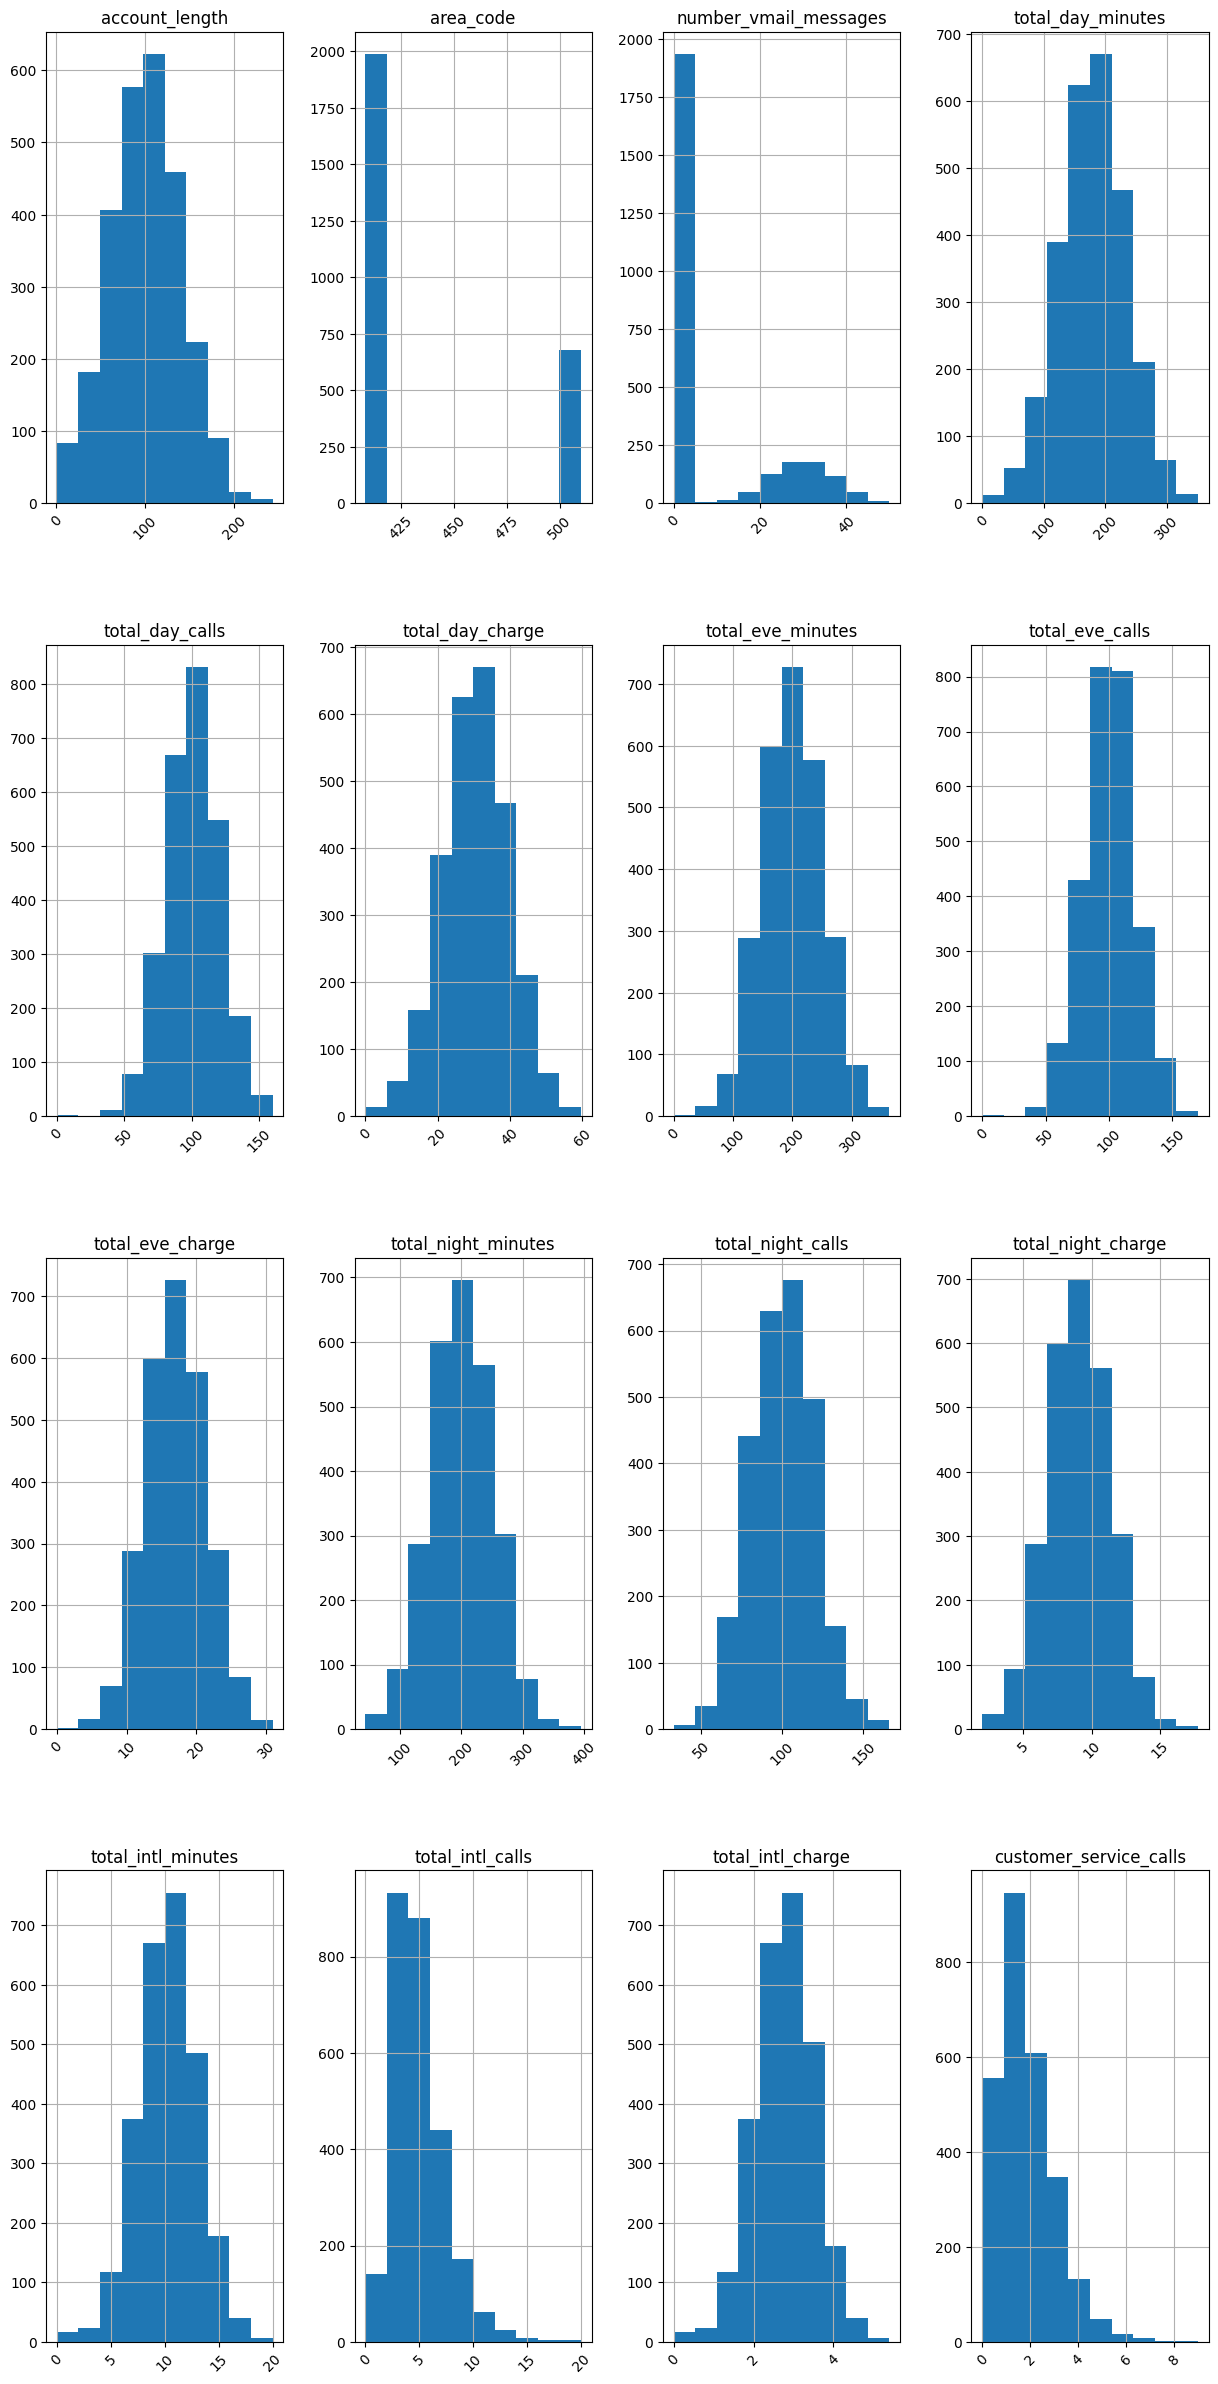

In [9]:
train.hist(figsize=(15,30), xrot=45);

Из гистограмм видно, что по большей части данные распределены нормально. Исключение - area_code и количество голосовых сообщений. По сути, area_code это скорее категориальный, чем числовой признак. В количестве голосовых сообщений самое частое значение - 0, т.к. у большей части абонентов голосовые сообщения не подключены.

Далее выявим корреляции признаков.

interval columns not set, guessing: ['account_length', 'area_code', 'number_vmail_messages', 'total_day_minutes', 'total_day_calls', 'total_day_charge', 'total_eve_minutes', 'total_eve_calls', 'total_eve_charge', 'total_night_minutes', 'total_night_calls', 'total_night_charge', 'total_intl_minutes', 'total_intl_calls', 'total_intl_charge', 'customer_service_calls']


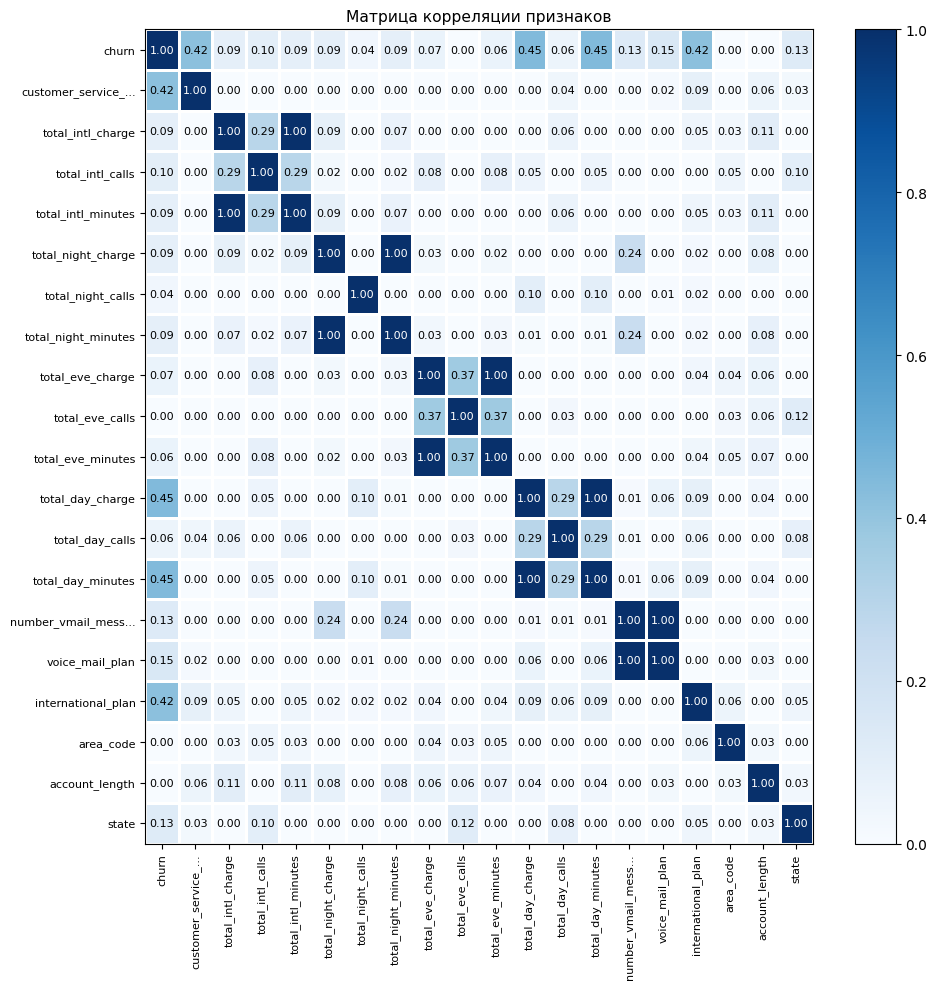

In [10]:
phik_overview = train.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', 
                        title='Матрица корреляции признаков', 
                        fontsize_factor=0.8, figsize=(10, 10))

Существует полная корреляция между несколькими признаками:
+ наличие подключенной опции голосовых сообщений и количество голосовых сообщений;
+ счет за звонки в день и количество минут разговора в день;
+ счет за вечерние звонки и количество минут разговора вечером;
+ счет за ночные звонки и количество минут разговора ночью;

Следовательно, признаки voice_mail_plan, total_day_charge, total_eve_charge и total_night_charge в дальнейшем можно удалить.

Также видна корреляция между целевым признаком и подключенным международным планом, количеством обращений в поддержку и количеством минут разговора в день. Визуализируем эти связи.

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

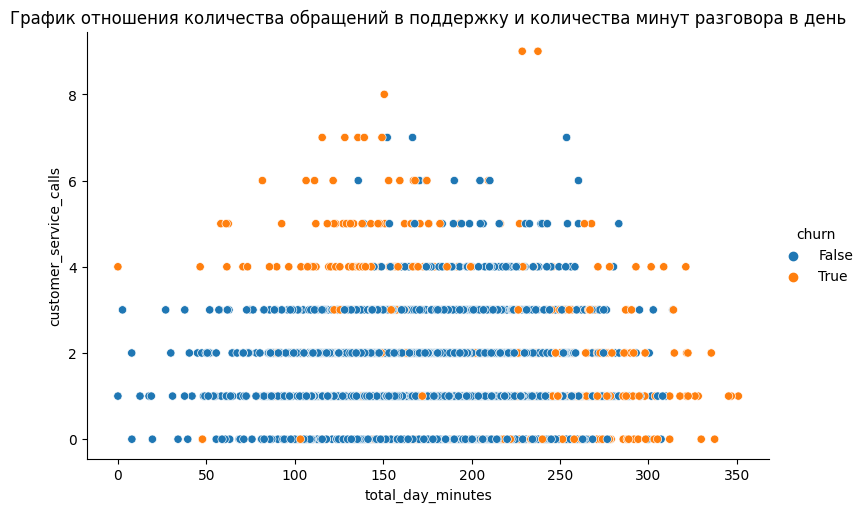

In [39]:
sns.relplot(
    data=train,
    x='total_day_minutes',
    y='customer_service_calls',
    kind='scatter',
    hue='churn',
    aspect=1.5,
 )

plt.title('График отношения количества обращений в поддержку и количества минут разговора в день')
plt.show();

Из графика видно интересное распредление - явно видны две группы пользователей, которые чаще расторгают договор:
1. Клиенты, которые говорят по телефону менее 150 минут в день и при этом обращались в поддержку 4-8 раз.
2. Клиенты, которые говорят по телефону более 275 минут в день и обращались в поддержку от 0 до 4 раз.

In [12]:
fig = px.histogram(train, x='international_plan',
                   title='Подключение к международному плану',
                   labels={'international_plan':'Международный план'},
                   opacity=0.7,
                   nbins=6,
                   color='churn',
                   color_discrete_map={0: '#00FA9A', 1: '#0000FF'}
                   )
fig.show()

Из графика видно, что среди тех, у кого подключен международный план, почти половина клиентов уходят.

### 4. Проверка гипотез

Проверим гипотезу - клиенты, у которых подключен международный план, расторгают договор чаще, чем клиенты без международного плана. Таким образом, гипотезы буду сформулированы следующим образом:

- **H0 — Нулевая гипотеза.**

*«Среднее количество расторжений договоров в выборке людей с международным планом A равно среднему количеству расторжений договоров в выборке B».*

- **H1 — Альтернативная гипотеза.**

*«Среднее количество расторжений договоров в выборке людей с международным планом A больше среднего количества расторжений договоров в выборке B».*

In [14]:
a = train.loc[train.international_plan == 'Yes']['churn'].values
b = train.loc[train.international_plan == 'No']['churn'].values

In [15]:
# проверим, сильно ли отличаются дисперсии
print(np.var(a), np.var(b))

0.24603566529492454 0.09998926981808859


Как правило, предполагают, что совокупности имеют равные дисперсии, если отношение большей выборочной дисперсии к меньшей выборочной дисперсии составляет менее 4:1. Здесь это условие выполняется.

In [16]:
alpha = .05
needed_value = a.mean()

_, pvalue = stats.ttest_1samp(b, popmean=needed_value)

pvalue /= 2

if (pvalue < alpha) and (b.mean() < needed_value):
    print(f'P-value:{pvalue:.5f}. Нулевая гипотеза отвергается')
else:
    print(f'P-value:{pvalue:.5f}. Подтверждается нулевая гипотеза')

P-value:0.00000. Нулевая гипотеза отвергается


Нулевая гипотеза отвергается - соответственно, мы можем утверждать, что среднее количество расторжений договора в выборке абонентов с подключенным международным планом выше, чем среди абонентов без международного плана.

### 5. Промежуточный отчет-вывод по исследованию

В выборке существует полная корреляция между несколькими признаками:
+ наличие подключенной опции голосовых сообщений и количество голосовых сообщений;
+ счет за звонки в день и количество минут разговора в день;
+ счет за вечерние звонки и количество минут разговора вечером;
+ счет за ночные звонки и количество минут разговора ночью;

Следовательно, признаки voice_mail_plan, total_day_charge, total_eve_charge и total_night_charge перед обучением модели нужно удалить.

Существует связь между целевым признаком и подключенным международным планом, количеством обращений в поддержку и количеством минут разговора в день. Абонетнты с подключенным международным палном расторгают договор чаще, чем остальные.

Классы целевого признака не сблансированы, необходимо учесть это перед обучением. Также необходима нормализация числовых признаков и кодирование категориальных признаков. 

### 6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

Так как целевой признак - бинарный, мы будем решать задачу классификации.

### 7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

Отделим целевой показатель от признаков.

In [17]:
x_train = train.drop(['churn'], axis=1)
x_test = test.drop(['churn'], axis=1)

y_train = train['churn']
y_test = test['churn']

Напишем трансформер для прямого кодирования признаков

In [18]:
class DataTransform(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):           
        X = pd.get_dummies(X, dtype=int, drop_first=True)        
        return X

Обернем все преобразования и модель логистической регрессии в пайплайн

In [44]:
pipe = Pipeline([  
    ('data_transform', DataTransform()),
    ('scaler', StandardScaler()),
    ('classify', LogisticRegressionCV(solver='liblinear', random_state=12,
     class_weight='balanced', cv=10))
])

Подберем лучшие параметры пайплайна с помощью GridSearch.

In [ ]:
params = [
    {'classify': [LogisticRegressionCV(class_weight='balanced', cv=3),
     random_state=0],
     'classify__solver': ['newton-cg', 'liblinear']},
    {'classify': [DecisionTreeClassifier(class_weight='balanced',
     random_state=0)],
     'classify__max_depth': [5, 10, 20]},
    {'classify': [XGBClassifier(class_weight='balanced', random_state=0)],
     'classify__max_depth': [5, 10, 20],
     'classify__n_estimators': [2, 4, 6],
     'classify__learning_rate': [0.01, 0.1, 0.5]},
    {'classify': [LGBMClassifier(class_weight='balanced', random_state=0)],
     'classify__num_leaves': [2, 10, 30],
     'classify__learning_rate': [0.01, 0.1, 0.5],
     'classify__subsample_for_bin': [50000, 100000, 150000],
     'classify__min_child_samples': [20, 50, 100],
     'classify__colsample_bytree': [0.6, 0.8, 1],
     'classify__max_depth': [5, 10, 50]},
    {'classify': [RandomForestClassifie(class_weight='balanced',
     random_state=0)],
     'classify__n_estimators': [2, 4, 6],
     'classify__min_samples_leaf': [2, 10, 30]} 
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X=x_train, y=y_train)

grid_search.best_score_


C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\data.py:440: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python

[LightGBM] [Info] Number of positive: 310, number of negative: 1822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 2132, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x0000022B59F04CC0>
Traceback (most recent call last):
  File "C:\Users\carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\basic.py", line 198, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Посмотрим на метрики топ-3 лучших моделей

In [89]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score',
             ascending=True).T

29  \
mean_fit_time                                                           0.056744   
std_fit_time                                                            0.003399   
mean_score_time                                                          0.01323   
std_score_time                                                          0.004269   
param_classify                 XGBClassifier(base_score=None, booster=None, c...   
param_classify__solver                                                       NaN   
param_classify__max_depth                                                      5   
param_classify__learning_rate                                                0.5   
param_classify__n_estimators                                                   4   
params                         {'classify': XGBClassifier(base_score=None, bo...   
split0_test_score                                                       0.949438   
split1_test_score                                                       0.939962   
split2_test_score                                                        0.95122   
split3_test_score                                                       0.953096   
split4_test_score                                                       0.953096   
mean_test_score                                                         0.949362   
std_test_score                                                          0.004893   
rank_test_score                                                                1   

                                                                              32  \
mean_fit_time                                                           0.080143   
std_fit_time                                                            0.022757   
mean_score_time                                                         0.016432   
std_score_time                                                          0.001159   
param_classify                 XGBClassifier(base_score=None, booster=None, c...   
param_classify__solver                                                       NaN   
param_classify__max_depth                                                     10   
param_classify__learning_rate                                                0.5   
param_classify__n_estimators                                                   4   
params                         {'classify': XGBClassifier(base_score=None, bo...   
split0_test_score                                                       0.940075   
split1_test_score                                                       0.934334   
split2_test_score                                                         0.9606   
split3_test_score                                                       0.949343   
split4_test_score                                                       0.949343   
mean_test_score                                                         0.946739   
std_test_score                                                          0.008989   
rank_test_score                                                                2   

                                                                              28  \
mean_fit_time                                                           0.051644   
std_fit_time                                                            0.003896   
mean_score_time                                                         0.015182   
std_score_time                                                          0.003054   
param_classify                 XGBClassifier(base_score=None, booster=None, c...   
param_classify__solver                                                       NaN   
param_classify__max_depth                                                      5   
param_classify__learning_rate                                                0.5   
param_classify__n_estimators                                                   3   
params                         {'classify': 

### 8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

Предсказываем вероятности принадлежности к классам с помощью лучшей модели.

In [22]:
predict = grid_search.predict_proba(x_test)

Преобразуем вероятности в метки классов.

In [23]:
labels = (predict[:, 1] > 0.5).astype(int)

### 9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)


Так как мы решаем задачу бинарной классификации, самой простой для интерпритации метрикой будет точность - доля верных предсказаний модели.

In [63]:
print(f'Качество модели на тестовой выборке c лучшей моделью: {round(accuracy_score(y_test, labels), 4)}')

Качество модели на тестовой выборке c лучшей моделью: 0.9565


Качество модели достаточно высокое. Построим матрицу ошибок.

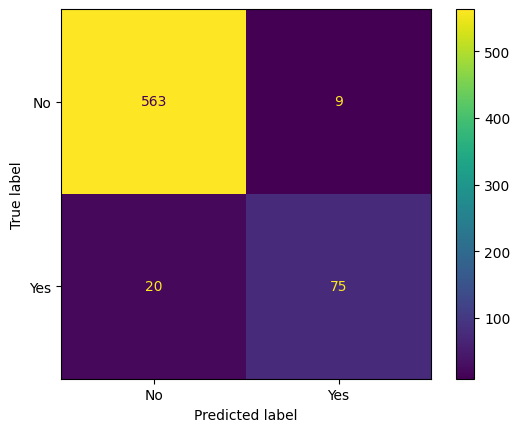

In [25]:
ConfusionMatrixDisplay(confusion_matrix(y_test, labels),
                       display_labels=['No', 'Yes']
                       ).plot();

### 10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

Чтобы оценить адекватность модели, сравним значение метрики accuracy на тестовой выборке с dummy-предсказанием.

In [26]:
model = DummyClassifier(strategy='uniform', random_state=0)
model.fit(x_train, y_train)

print(f'Качество модели на тестовой выборке c dummy-моделью: {round(accuracy_score(y_test, model.predict(x_test)), 4)}')

Качество модели на тестовой выборке c dummy-моделью: 0.4723


Как видно, точность лучшей модели - логистической регресии - значительно выше dummy-предсказания: 0.9565 против 0.4723. Следовательно, применение машинного обучения для решения поставленной задачи обосновано.